<a href="https://colab.research.google.com/github/ekinfergan/Thesis_Jupyter_Final/blob/main/src/models/rnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - LSTM & GRU

In [1]:
!git clone https://github.com/ekinfergan/Thesis_Jupyter_Final.git

Cloning into 'Thesis_Jupyter_Final'...
remote: Enumerating objects: 1059, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 1059 (delta 229), reused 404 (delta 168), pack-reused 580
Receiving objects: 100% (1059/1059), 192.14 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (547/547), done.
Updating files: 100% (92/92), done.


In [2]:
%cd Thesis_Jupyter_Final
!git pull
%cd ..


/content/Thesis_Jupyter_Final
Already up to date.
/content


In [3]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-n75sf6n0
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-n75sf6n0
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-23.5.9-py3-none-any.whl (17 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100250 sha256=465514bcaa6f2f714c562abc8431175e093d98e5cf3cb2e06f582962f8149cef
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6qt2c41/wheels/2f/f0/ed/db529a96372d05bd34f6c3a2fa7c08ef7a8314315ac46e49d7
Successfully built scikit-optimize


In [4]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle
from numpy import asarray

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense, LSTM, GRU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop, Adagrad

import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import backend as K

import functools

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
# just checkıng gpu ıs avaılable


try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy()

Sat Jun 24 23:42:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
script_dir = os.path.dirname(os.path.abspath('mc_lstm-fix.ipynb'))
data_path = os.path.join(script_dir, 'Thesis_Jupyter_Final/src/')
os.getcwd()
print(data_path)

input_folder_path = os.path.join(data_path, 'input')
processed_folder_path = os.path.join(data_path, 'input/processed/normal')
results_folder_path =  os.path.join(data_path, "results")

# Create the folder if it doesn't exist
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

/content/Thesis_Jupyter_Final/src/


In [7]:
senti_labels_dict = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_labels_names = list(senti_labels_dict.values())
senti_labels_nums = list(senti_labels_dict.keys())
NUM_of_CLASSES = 3

VOCAB_SIZE = 11395
MAX_SEQ_LEN = 449
EMBEDDING_DIM = 100
NUM_OUTPUT_CLASSES = 3

In [8]:
train = pd.read_csv(os.path.join(processed_folder_path, "train.csv"))
val = pd.read_csv(os.path.join(processed_folder_path, "val.csv"))
test = pd.read_csv(os.path.join(processed_folder_path, "test.csv"))

x_train = train['x']
y_train = train['y']
x_val = val['x']
y_val = val['y']
x_test = test['x']
y_test = test['y']
import pickle

# Load encoded sequences
with open(os.path.join(processed_folder_path, "x_train_encoded.pkl"), "rb") as f:
    x_train_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_val_encoded.pkl"), "rb") as f:
    x_val_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_test_encoded.pkl"), "rb") as f:
    x_test_encoded = pickle.load(f)
print(f"x_train_encoded:\n{x_train_encoded[:5]}\n")

# Load embedding vectors
with open(os.path.join(processed_folder_path, "embedding_matrix.pkl"), "rb") as f:
    w2v_embedding_vectors = pickle.load(f)
print(f"embedding vectors: {w2v_embedding_vectors[10][:5]}...\n")

# Load encoded labels
with open(os.path.join(processed_folder_path, "y_train_encoded.pkl"), "rb") as f:
    y_train_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "y_val_encoded.pkl"), "rb") as f:
    y_val_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "y_test_encoded.pkl"), "rb") as f:
    y_test_encoded = pickle.load(f)
print(f"y_train_encoded:\n{y_train_encoded[:5]}\n")

x_train_encoded:
[[  96  549  929 ...    0    0    0]
 [ 453  240 1125 ...    0    0    0]
 [1260   67  312 ...    0    0    0]
 [ 127 1352 6694 ...    0    0    0]
 [ 529   10   69 ...    0    0    0]]

embedding vectors: [-0.57674998 -0.42304999  0.27188    -0.31986001  0.18842   ]...

y_train_encoded:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]



## Evaluation Functions

In [9]:
def one_hot_encode(y):
    y_encoded = np.zeros((len(y), NUM_of_CLASSES))
    for i, label in enumerate(y):
        y_encoded[i, label - 1] = 1

    return y_encoded

def calculate_classification_report(y, y_pred):
    report = classification_report(y, y_pred, labels=senti_labels_nums, target_names=senti_labels_names)
    return report

def plot_confusion_matrix(y_true, y_pred, res_path):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=senti_labels_names)
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(res_path, "confusion_matrix.png"))
    plt.close()

def plot_roc_curve(prob_test_vec, y_test, res_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = cycle(['limegreen', 'dodgerblue', 'red'])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y_test[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {senti_labels_names[senti]}",
            color=color,
            ax=ax,
        )
    plt.savefig(os.path.join(res_path, "roc_curve.png"))
    plt.close()

def calculate_OvR_roc_auc_score(model, model_name, x_test, y_test, res_path):
    prob_test_vec = model.predict(x_test)

    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)

     # Determine class proportions which will be the weights for the average
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    class_proportions = y_test_bin.mean(axis=0)

    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    weighted_avg_auc_score = np.average(auc_score, weights=class_proportions)
    # Save AUC to results.txt
    with open(os.path.join(res_path, f"{model_name}_results.txt"), "a") as f:
        auc_score_str = ', '.join(f'{score:.2f}' for score in auc_score)
        f.write(f"AUC score: [{auc_score_str}]\n")
        f.write(f"Weighted average AUC score: {weighted_avg_auc_score:.2f}\n")

    plot_roc_curve(prob_test_vec, y_test, res_path)

def get_results(y_pred, y, x, score, history, model, model_name, params, res_path):
    if not os.path.exists(res_path):
        os.makedirs(res_path)

    # Convert to one hot vectors
    y_classes = np.argmax(y, axis=1) + 1
    y_pred_classes = np.argmax(y_pred, axis=1) + 1

    print(y_pred.shape)
    print(y_classes.shape)
    print(y_pred_classes.shape)

    print(f"Accuracy: {score[1]:.2%}")
    print(f"Loss: {score[0]:.2f}")

    with open(os.path.join(res_path, f"{model_name}_results.txt"), "w") as f:
        f.write(f"*{model_name}\n")
        f.write(f"Optimizer Params: {params}\n\n")

        f.write(f"Accuracy: {score[1]:.2f}%\n")
        f.write(f"Loss: {score[0]:.2f}\n")

        report = calculate_classification_report(y_classes, y_pred_classes)
        if report is not None:
            f.write("Classification Report:\n")
            f.write(report)
        else:
            print("Failed to generate classification report")
        f.write("\n")

        plot_confusion_matrix(y_classes, y_pred_classes, res_path)

        # TODO:
        calculate_OvR_roc_auc_score(model, model_name, x, y, res_path)

In [10]:
def plot_development(history, model_name):
    acc =  history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{model_name} Training and Validation Accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{model_name} Training and Validation Loss")
    plt.legend()
    plt.show()

    plt.savefig(os.path.join(results_folder_path, f"{model_name}_development_plot.png"))
    plt.close()

JUST CHECKING IF IT WORKS AT ALL WITH A SIMPLE MODEL

In [ ]:
K.clear_session()

model = Sequential()
# input layer is sequence of integers (words)
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddings_layer")) # part of input layer as it transforms integers into dense vectors, input shape = (None, MAX_SEQ_LEN)
model.add(LSTM(64, name='hidden_layer')) # hidden layer
model.add(Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output_layer"))
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

history = model.fit(x_train_encoded, y_train_encoded, validation_data=(x_val_encoded, y_val_encoded), batch_size=16, epochs=1)

y_pred = model.predict(x_test_encoded)
score = model.evaluate(x_test_encoded, y_test_encoded)

get_results(y_pred, y_test_encoded, x_test_encoded, score, history, model, "LSTM", model.optimizer.get_config(), results_folder_path)

del model

K.clear_session()
tf.compat.v1.reset_default_graph()

In [27]:
K.clear_session()

batch_size= 16
epochs=1


num_units = Categorical([32, 64, 128], name='num_units')
learning_rate = Categorical([0.1, 1e-2], name='learning_rate')

search_space = [
            learning_rate
            ]

# Specify one or more initial points for the search of optimal parameter
default_params = [
                  0.1
                  ]

def define_model(learning_rate, layer_type):
    # input layer
    inputs = Input(shape=(MAX_SEQ_LEN,), name="input glove embeddings")

    # Define an embedding layer for the input
    embeddings = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddings")(inputs)

    # Pass embeddings through their own LSTM or GRU layers
    layers = layer_type(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name="layer_1")(embeddings)
    layers = layer_type(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, name="layer_2")(layers)

    # Dense layer for the merged inputs & output Layer
    outputs = Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output")(layers)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    rmsprop = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=rmsprop, loss='mean_squared_error', metrics=['accuracy']) # default learning rate = 0.001
    print(model.summary())

    return model

In [28]:
def get_objective_function(layer_type):
    @use_named_args(dimensions=search_space)
    def objective_function(learning_rate):
        model = define_model(learning_rate=learning_rate,
                            layer_type=layer_type
                            )

        print("Optimization, starting training...")
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(x_train_encoded,
                            y_train_encoded,
                            validation_data=(x_val_encoded, y_val_encoded),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=2
                            )
        print("Training Complete")
        # Return the validation accuracy for the last epoch.
        accuracy = history.history['val_accuracy'][-1]
        loss = history.history['val_loss'][-1]

        # Print the classification accuracy.
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Loss: {loss:.2}\n")

        del model,

        print('Model deleted. Clearing session...')

        # Clear the session.
        K.clear_session()
        tf.compat.v1.reset_default_graph()

        # The optimizer aims for the lowest score, so we return our negative accuracy.
        return -accuracy

    return objective_function

In [34]:
def perform_bayesian_opt(objective_function):
    # Perform Bayesian Optimization
    gbrt_result = gbrt_minimize(func=objective_function,
                                dimensions=search_space,
                                n_calls=12,
                                n_jobs=-1,
                                x0=default_params)

    gbrt_best_params = {param.name: value for param, value in zip(gbrt_result.space, gbrt_result.x)}
    print("Best Hyperparameters:", gbrt_best_params)
    print()

    return gbrt_best_params

def fit_model(model, model_name, x_train, y_train, x_val, y_val):
    model_file = f"model_{model_name}.h5"
    model_path = os.path.join(results_folder_path, model_file)

    # Check if the model exists
    if os.path.exists(model_path):
        # If the model exists, then load it
        model = load_model(model_path)
        print(f"Model {model_name} loaded successfully")
    else:
        print("Fitting best model...")
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=2,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=2)

        model.save(model_path)
        print(f"Model {model_name} saved at {model_path}")

    return model, history

def init_results(model, model_name, x_train, y_train, x_val, y_val, x_test, y_test):
    subfolder_path = f"{model_name}_results"
    res_path = os.path.join(results_folder_path, subfolder_path)
    print("Saving best results...")

    y_pred = model.predict(x_train)
    score = model.evaluate(x_train, y_train)
    get_results(y_pred, y_train, x_train, score, model, f"Train {model_name}", model.optimizer.get_config(), res_path)

    y_pred = model.predict(x_val)
    score = model.evaluate(x_val, y_val)
    get_results(y_pred, y_val, x_val, score, model, f"Val {model_name}", model.optimizer.get_config(), res_path)

    y_pred = model.predict(x_test)
    score = model.evaluate(x_test, y_test)
    get_results(y_pred, y_test, x_test, score, model, f"Test {model_name}", model.optimizer.get_config(), res_path)


def setup_dl(model_name):
    '''
    if model_name == "LSTM":
        objective_function = get_objective_function(LSTM)
    else:
        objective_function = get_objective_function(GRU)

    best_params = perform_bayesian_opt(objective_function)
    '''

    # Fit best model
    model = define_model(0.1,  #best_params['learning_rate'],
                         LSTM if model_name == "LSTM" else GRU)


    best_model, history = fit_model(model, model_name, x_train_encoded, y_train_encoded, x_val_encoded, y_val_encoded)

    # Get results
    plot_development(history, model_name)
    init_results(best_model, model_name, x_train_encoded, y_train_encoded, x_val_encoded, y_val_encoded, x_test_encoded, y_test_encoded)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input glove embeddings (Inp  [(None, 449)]            0         
 utLayer)                                                        
                                                                 
 embeddings (Embedding)      (None, 449, 100)          1139500   
                                                                 
 layer_1 (LSTM)              (None, 449, 64)           42240     
                                                                 
 layer_2 (LSTM)              (None, 32)                12416     
                                                                 
 output (Dense)              (None, 3)                 99        
                                                                 
Total params: 1,194,255
Trainable params: 54,755
Non-trainable params: 1,139,500
____________________________________________

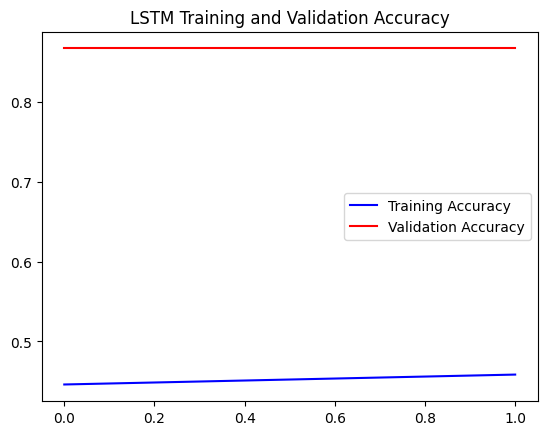

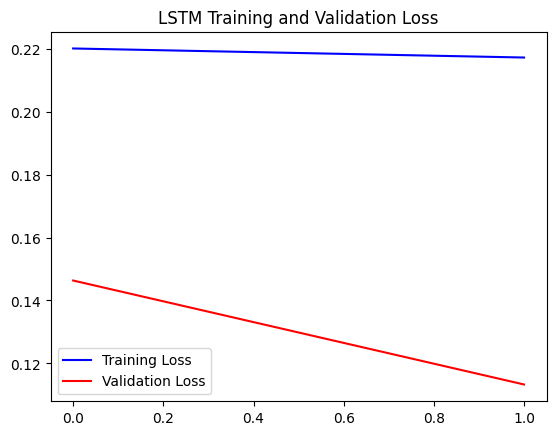

Saving best results...
1282/1282 [==============================] - 319s 248ms/step - loss: 0.2179 - accuracy: 0.4878


TypeError: ignored

In [35]:
setup_dl("LSTM")

In [ ]:
setup_dl("GRU")